In [25]:
from PIL import Image
import PIL
import os
import torch
torch.backends.cudnn.benchmark = True
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import random
from torchvision import transforms
import torchvision.datasets as dset
import numpy as np
from tqdm import tqdm
import imagehash
import shutil
import cv2
import matplotlib.pyplot as plt
import math
from glob import glob
import gc

In [26]:
!python --version

Python 3.11.9


In [27]:
source_directory = "./data/Humans"
destination_directory = "./data/Faces_Cleaned/Base"
organic_mask_directory = "./data/VOC_2012_masks"


In [28]:
image_paths = [f for f in glob(os.path.join(destination_directory, "*.*")) 
               if os.path.isfile(f) and f.lower().endswith(".jpg")]
organic_mask_list = image_paths = [f for f in glob(os.path.join(organic_mask_directory, "*.*")) 
               if os.path.isfile(f) and f.lower().endswith(".png")]
print(len(organic_mask_list))

2901


In [42]:
organic_mask_list = image_paths = [f for f in glob(os.path.join(organic_mask_directory, "*.*")) 
               if os.path.isfile(f) and f.lower().endswith(".png")]
len(organic_mask_list)

#k = 0
for path in organic_mask_list:
    #k+=1
    #print(k, end = " ")
    image_size = (224,224)
    width, height = image_size
    random_mask_path = path
    random_mask_unsized = cv2.imread(random_mask_path)
    random_mask_resized = cv2.resize(random_mask_unsized, image_size)
    #print(np.unique(random_mask_resized))
    
    binary_mask_resized = np.zeros(image_size)
    binary_mask_resized[np.any(random_mask_resized > 5, axis = 2)] = 1
    current_mask_area = np.count_nonzero(binary_mask_resized)
    eroded_pixel_test = max(int(current_mask_area * .3), 0)
    dilated_pixel_test = min(int(current_mask_area * 1.3), width*height)
    
    #https://www.geeksforgeeks.org/python-opencv-cv2-erode-method/
    mask = np.copy(binary_mask_resized)
    kernel = np.ones((3, 3), np.uint8)
    
    
    new_mask_area = 0
    type_of_transformation = None
    i = 0
    if(current_mask_area > eroded_pixel_test):
        #print("Erosion neccesary")
        new_mask_area = current_mask_area 
        while (new_mask_area > eroded_pixel_test) & (i <= 1000):
            i+=1
            mask = cv2.erode(mask, kernel)
            new_mask_area = np.count_nonzero(mask)
            #print("Iteration", i)
            
        
    j = 0    
    if(current_mask_area < dilated_pixel_test):
        #print("Dilation neccesary")
        new_mask_area = current_mask_area
        while (new_mask_area < dilated_pixel_test) & (j <= 1000):
            j+=1
            mask = cv2.dilate(mask, kernel)
            new_mask_area = np.count_nonzero(mask)
            #print("Iteration", i)
    occluded_pixel_amount = None
    if((i == 1001) or (j == 1001)):
        if i == 1001 and j == 1001: 
            occluded_pixel_amount = [eroded_pixel_test, dilated_pixel_test]
            type_of_transformation = "Dilation and Erosion"
        elif i == 1001:
            occluded_pixel_amount = eroded_pixel_test
            type_of_transformation = "Erosion"
        elif j == 1001:
            occluded_pixel_amount = dilated_pixel_test
            type_of_transformation = "Dilation"
        #fig, axes = plt.subplots(1, 1, figsize=(15, 5))
        print(f"Error with {type_of_transformation}. Old mask area: {current_mask_area}, Needed mask area {occluded_pixel_amount}, path name {random_mask_path}")
        print("Removing file to ensure working masks for later")
        os.remove(random_mask_path)

KeyboardInterrupt: 

In [29]:

def create_square_mask(image_size, occlusion_percentage):
    width, height = image_size
    mask_area = int(width * height * occlusion_percentage)
    side_length = int(np.sqrt(mask_area))
    side_length = min(side_length, width, height)
    
    start_x = (width - side_length) // 2
    start_y = (height - side_length) // 2
    
    mask = np.zeros((height, width), dtype=np.uint8)
    mask[start_y:start_y + side_length, start_x:start_x + side_length] = 1
    
    return mask

# Function to create multiple small square masks
def create_multiple_square_masks(image_size, occlusion_percentage):
    width, height = image_size
    mask_area = int(width * height * occlusion_percentage)
    
    mask = np.zeros((height, width), dtype=np.uint8)
    
    area_covered = 0
    while area_covered < mask_area:
        side_length = random.randint(5, 20)
        x = random.randint(0, width - side_length)
        y = random.randint(0, height - side_length)
        
        mask[y:y + side_length, x:x + side_length] = 1
        area_covered += side_length * side_length
    
    return mask
def create_organic_masks(image_size, occlusion_percentage):
    width, height = image_size
    random_mask_path = organic_mask_list[random.randint(0, len(organic_mask_list)-1)]
    random_mask_unsized = cv2.imread(random_mask_path)
    random_mask_resized = cv2.resize(random_mask_unsized, image_size)
    #print(np.unique(random_mask_resized))
    
    binary_mask_resized = np.zeros(image_size)
    binary_mask_resized[np.any(random_mask_resized >= 20, axis = 2)] = 1
    occluded_pixel_amount = int((width*height)*occlusion_percentage)
    current_mask_area = np.count_nonzero(binary_mask_resized)
    
    #https://www.geeksforgeeks.org/python-opencv-cv2-erode-method/
    mask = np.copy(binary_mask_resized)
    kernel = np.ones((3, 3), np.uint8)
    
    
    new_mask_area = 0
    type_of_transformation = None
    i = 0
    if(current_mask_area > occluded_pixel_amount):
        #print("Erosion neccesary")
        new_mask_area = current_mask_area 
        type_of_transformation = "Erosion"
        while (new_mask_area > occluded_pixel_amount) & (i <= 1000):
            i+=1
            mask = cv2.erode(mask, kernel)
            new_mask_area = np.count_nonzero(mask)
            #print("Iteration", i)
            
        
        
    elif(current_mask_area < occluded_pixel_amount):
        #print("Dilation neccesary")
        new_mask_area = current_mask_area
        type_of_transformation = "Dilation"
        while (new_mask_area < occluded_pixel_amount) & (i <= 1000):
            i+=1
            mask = cv2.dilate(mask, kernel)
            new_mask_area = np.count_nonzero(mask)
            #print("Iteration", i)
    else:
        #print("No change neccesary")
        mask = mask
    if(i == 1001):
        fig, axes = plt.subplots(1, 1, figsize=(15, 5))
        axes.imshow(binary_mask_resized*255,cmap = "grey")
        axes.set_title("Faulty Mask")
        axes.axis('off')
        raise RuntimeError(f"Error with {type_of_transformation}. Old mask area: {current_mask_area}, Needed mask area {occluded_pixel_amount}, current mask area {new_mask_area}, path name {random_mask_path}")
    return mask
    
    
    
                                
'''
# Function to create an irregular VOC2012-like mask
def create_irregular_mask(image_size, occlusion_percentage):
    width, height = image_size
    mask_area = int(width * height * occlusion_percentage)
    
    mask = np.ones((height, width), dtype=np.uint8)
    
    while mask_area > 0:
        shape_type = random.choice(["rectangle", "ellipse"])
        if shape_type == "rectangle":
            rect_width = random.randint(20, 50)
            rect_height = random.randint(20, 50)
            x = random.randint(0, width - rect_width)
            y = random.randint(0, height - rect_height)
            mask[y:y+rect_height, x:x+rect_width] = 0
            mask_area -= rect_width * rect_height
        else:
            rect_width = random.randint(20, 50)
            rect_height = random.randint(20, 50)
            x = random.randint(0, width - rect_width)
            y = random.randint(0, height - rect_height)
            rr, cc = np.ellipse(x + rect_width//2, y + rect_height//2, rect_width//2, rect_height//2, shape=mask.shape)
            mask[rr, cc] = 0
            mask_area -= rect_width * rect_height
    
    return mask
'''


# Custom Dataset Class for Inpainting (Return 9 Variations per Image)
class CustomInpaintingDataset(Dataset):
    def __init__(self, image_paths, occlusion_percentages=[0.10, 0.15, 0.25], transform=None):
        """
        :param image_paths: List of paths to images
        :param occlusion_percentages: List of occlusion percentages (e.g., 0.10, 0.25, 0.50)
        :param transform: Optional transform for the image
        """
        self.image_paths = image_paths
        self.occlusion_percentages = occlusion_percentages
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths) * len(self.occlusion_percentages) * 3  # 3 mask types
    
    def __getitem__(self, idx):
        
        img_idx = idx // (len(self.occlusion_percentages) * 3)
        mask_idx = idx % (len(self.occlusion_percentages) * 3)
        
        
        image = Image.open(self.image_paths[img_idx]).convert("RGB")
        width, height = image.size
        if self.transform:
            image = self.transform(image)
        else:
            
            to_tensor = transforms.ToTensor()
            image = to_tensor(image)

        to_pil = transforms.ToPILImage()

        # Make sure the tensor is in the correct shape (C, H, W)
        image= to_pil(image) 
        
        occlusion_percentage = self.occlusion_percentages[mask_idx % len(self.occlusion_percentages)]
        
        if mask_idx < 3:
            mask = create_square_mask((width, height), occlusion_percentage)  # Center square mask
        elif mask_idx < 6:
            mask = create_multiple_square_masks((width, height), occlusion_percentage)  # Multiple small squares
        else:
            mask = create_organic_masks((width, height), occlusion_percentage)  # Irregular mask
        
        
        masked_image = np.array(image)
        masked_image[mask == 1] = 0
        
        
        masked_image = Image.fromarray(masked_image)

        
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        masked_image = to_tensor(masked_image)
        """
        if self.transform:
            image = self.transform(image)
            masked_image = self.transform(masked_image)
        else:
            
            to_tensor = transforms.ToTensor()
            image = to_tensor(image)
            masked_image = to_tensor(masked_image)
        """
        
        return masked_image, image, torch.tensor(mask, dtype=torch.float32)






In [30]:
image_paths = [f for f in glob(os.path.join(destination_directory, "*.*")) 
               if os.path.isfile(f) and f.lower().endswith(".jpg")]


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
    
])
#transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),

full_dataset = CustomInpaintingDataset(image_paths, occlusion_percentages=[0.10, 0.15, 0.25], transform = transform)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size,val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

475
60
60


475
Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


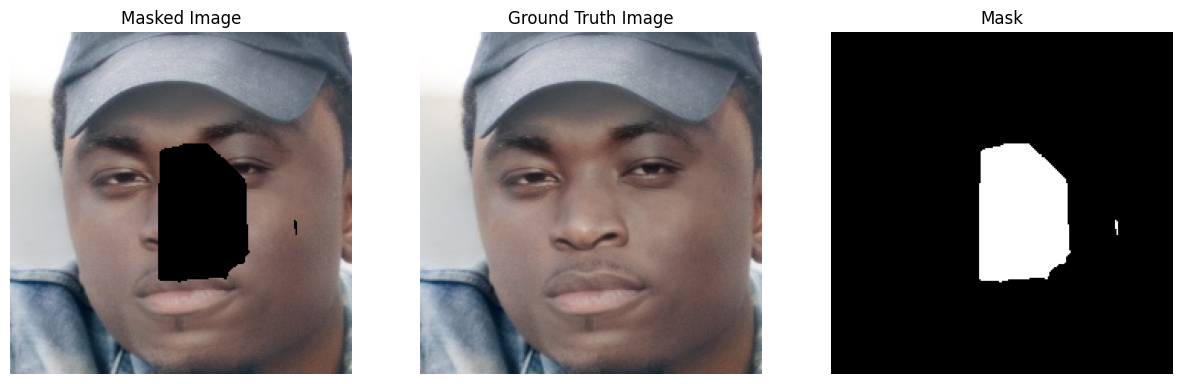

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


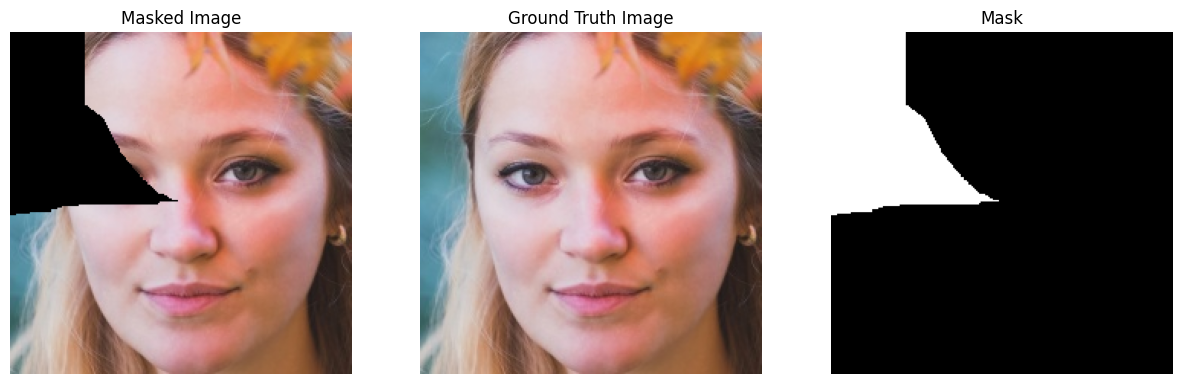

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


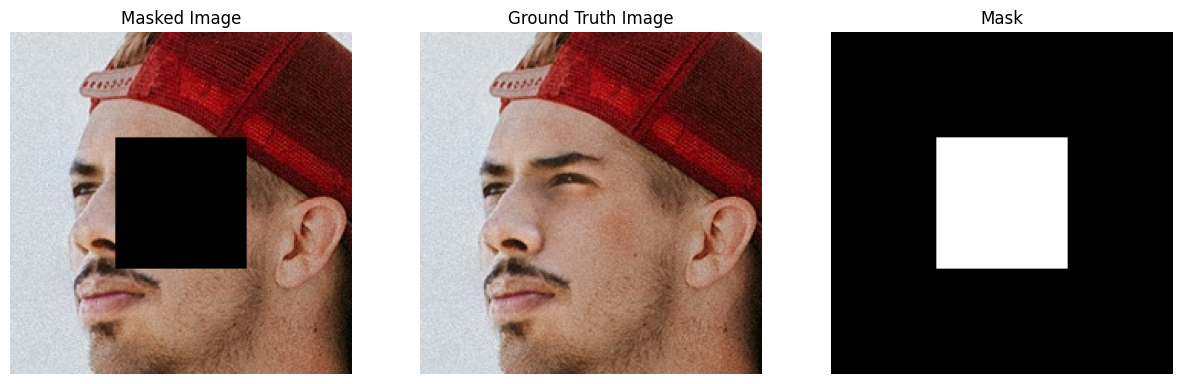

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


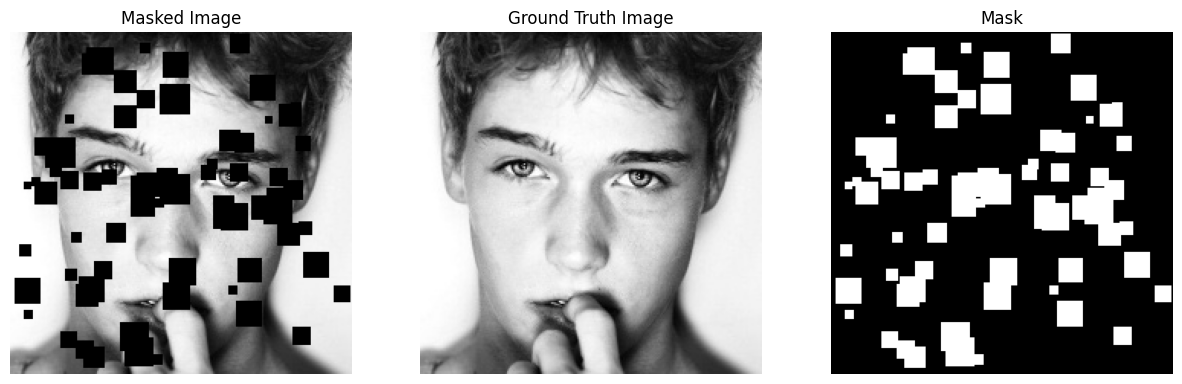

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


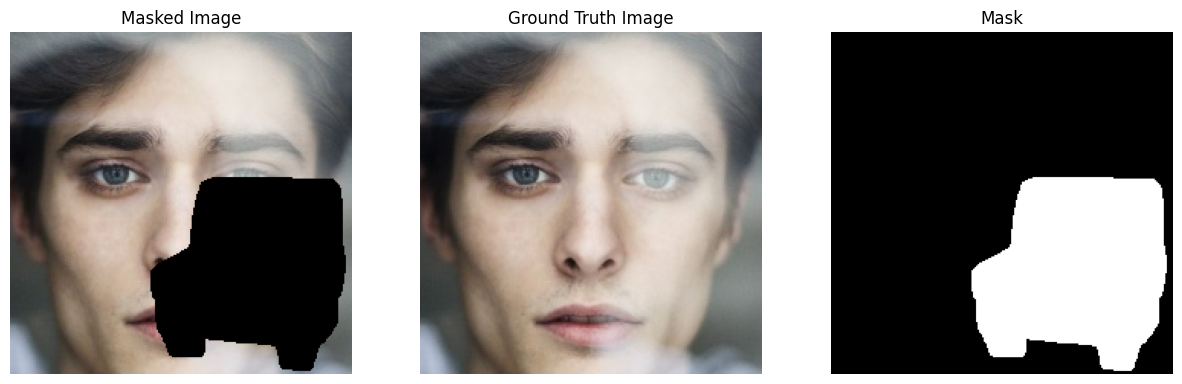

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


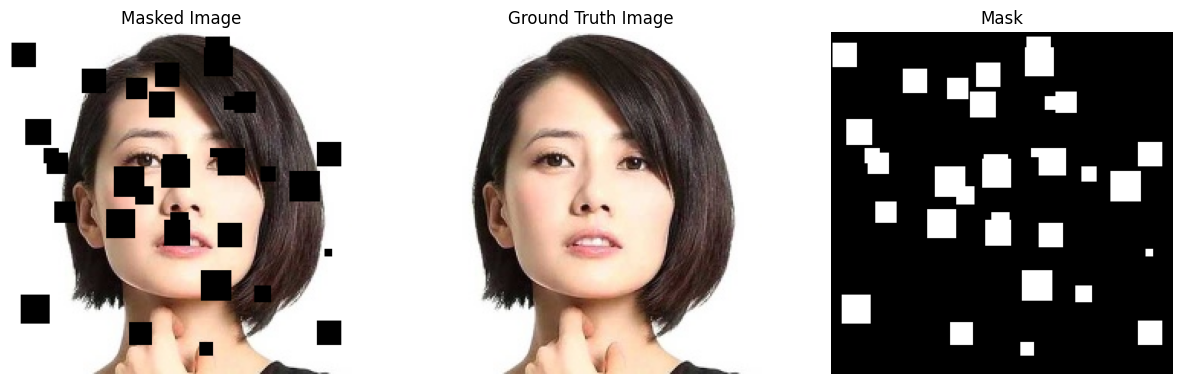

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


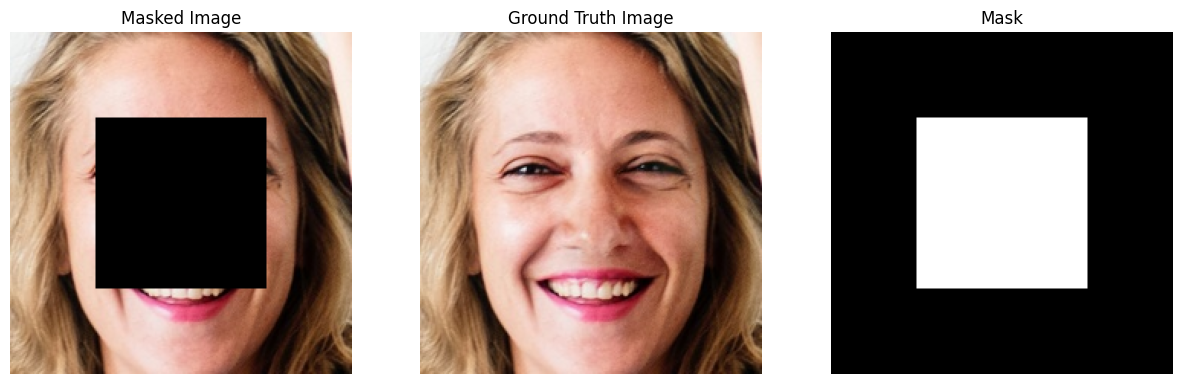

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


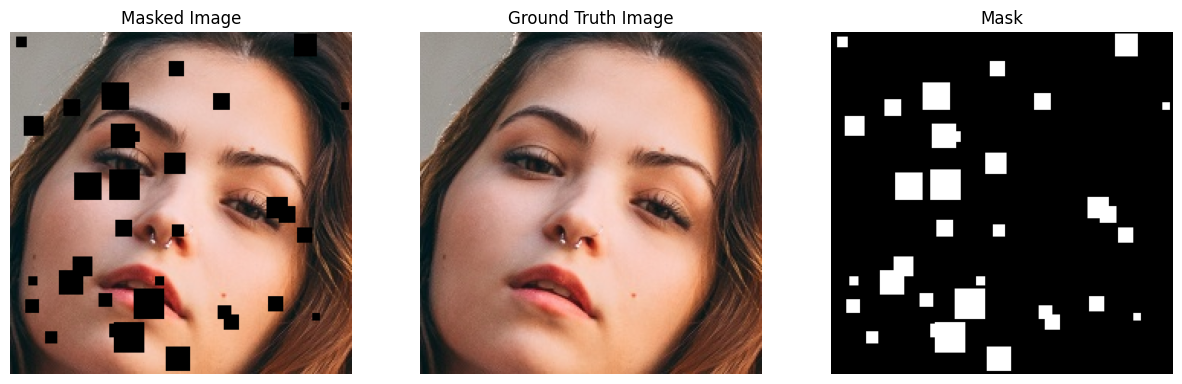

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


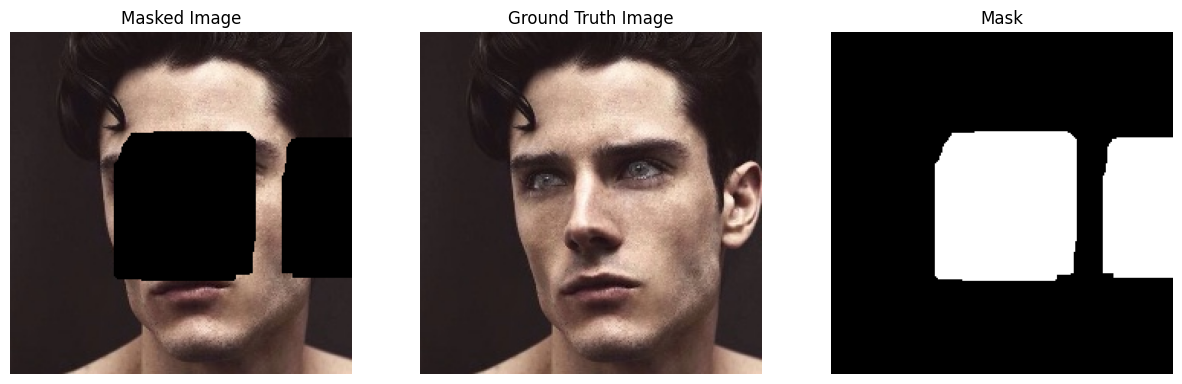

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


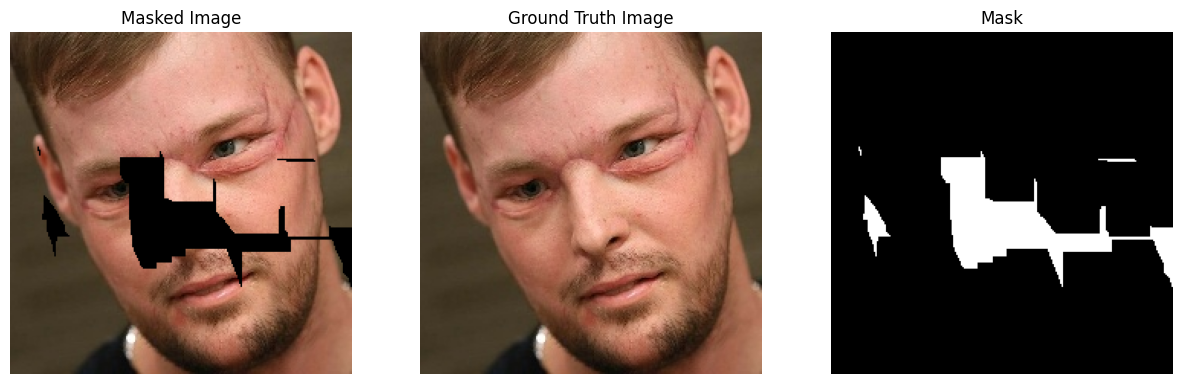

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


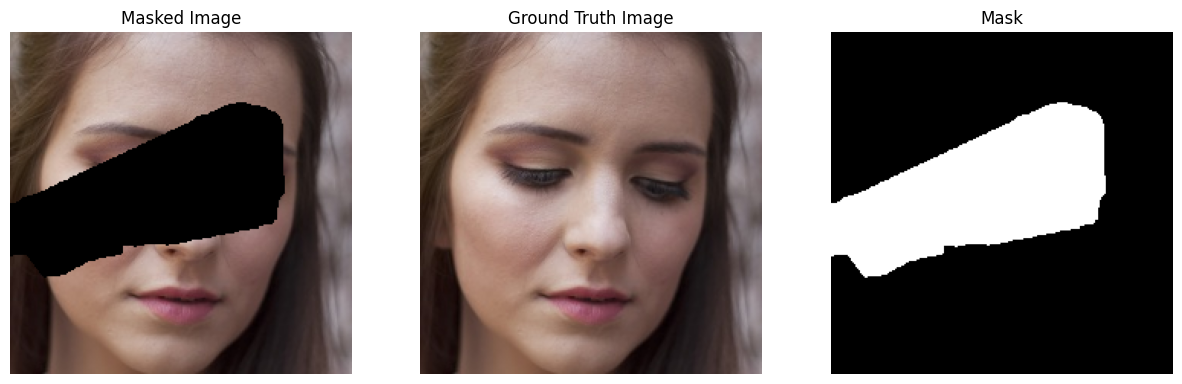

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


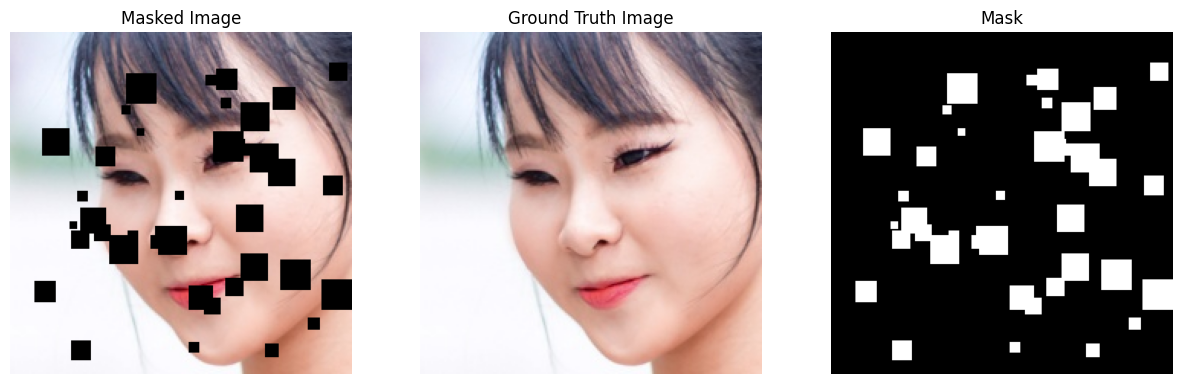

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


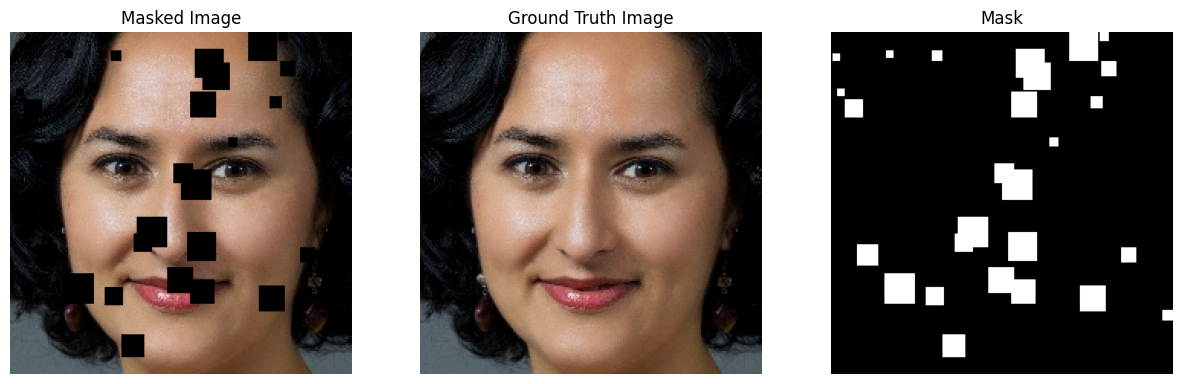

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


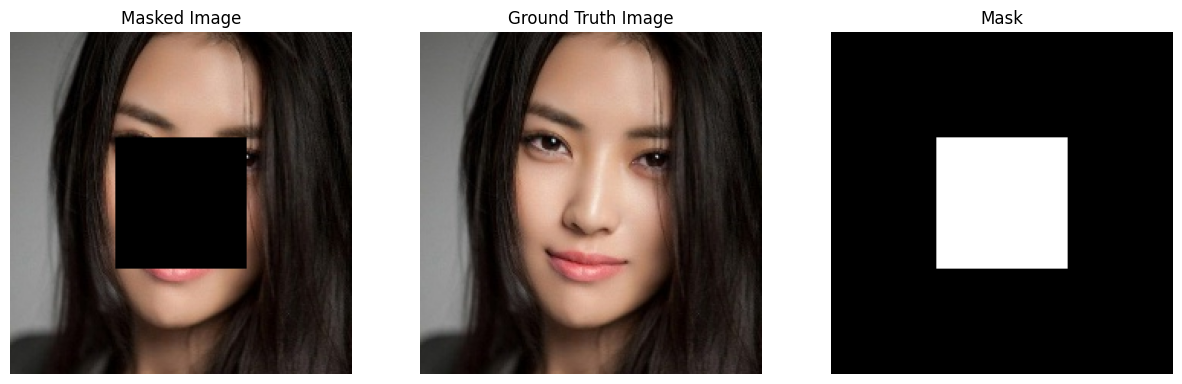

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


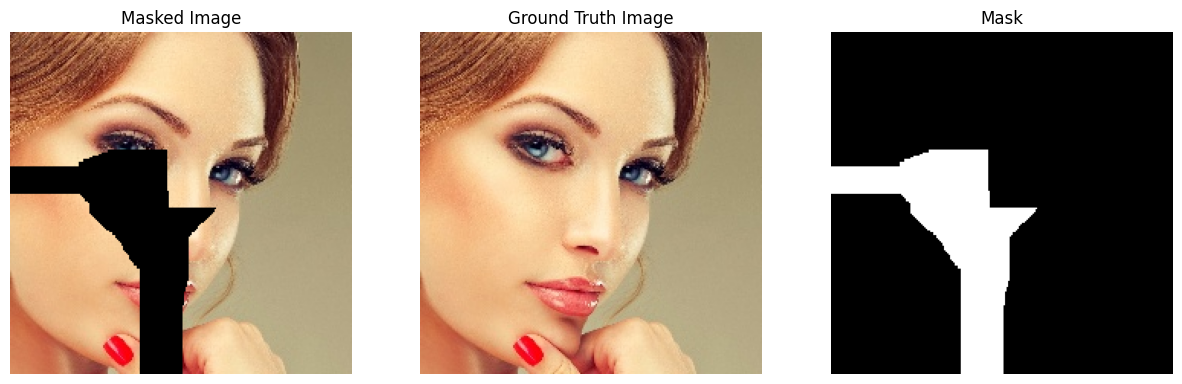

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


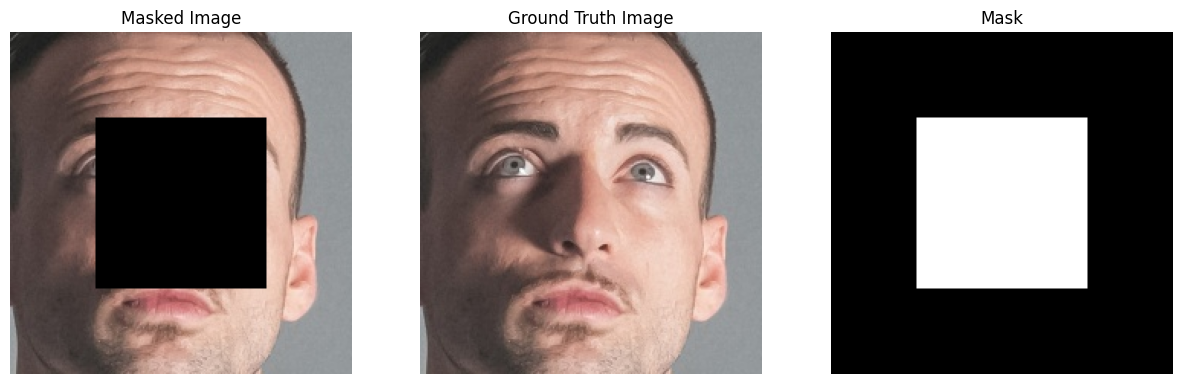

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


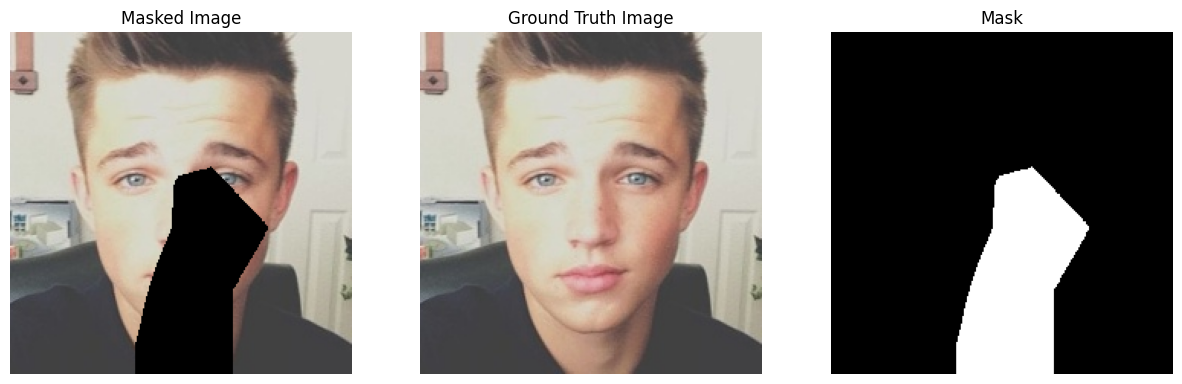

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


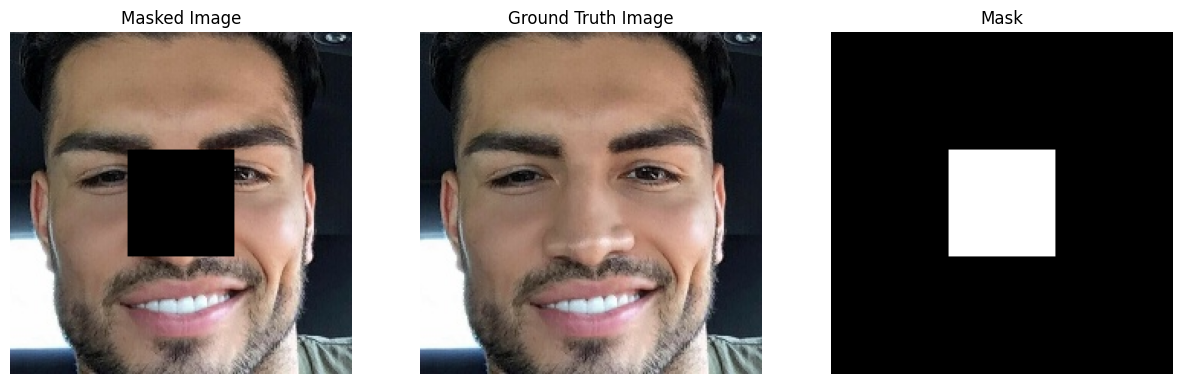

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


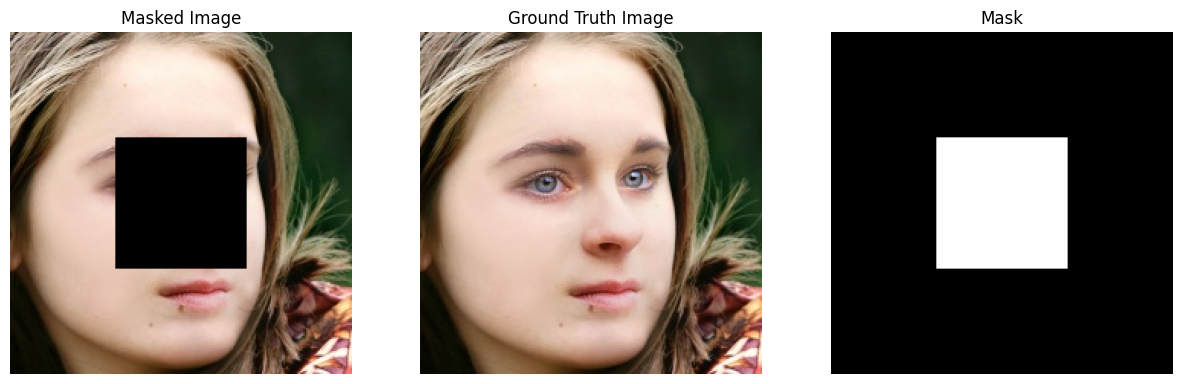

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


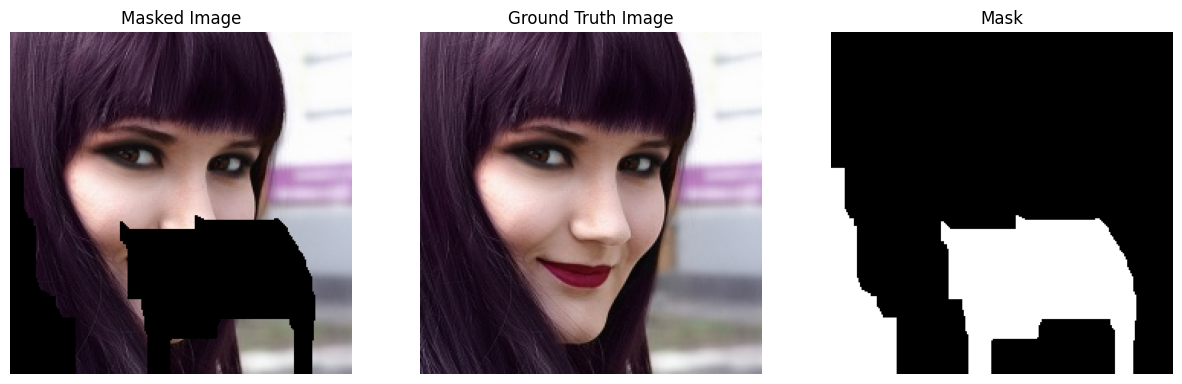

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


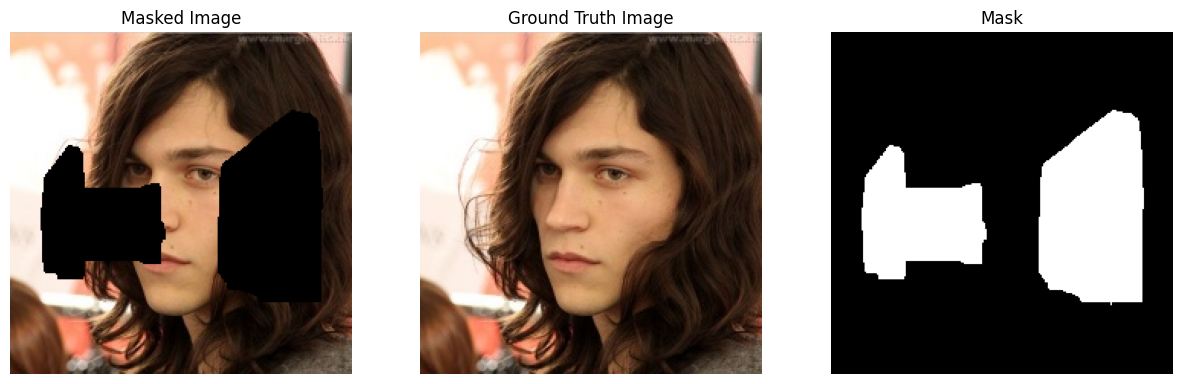

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


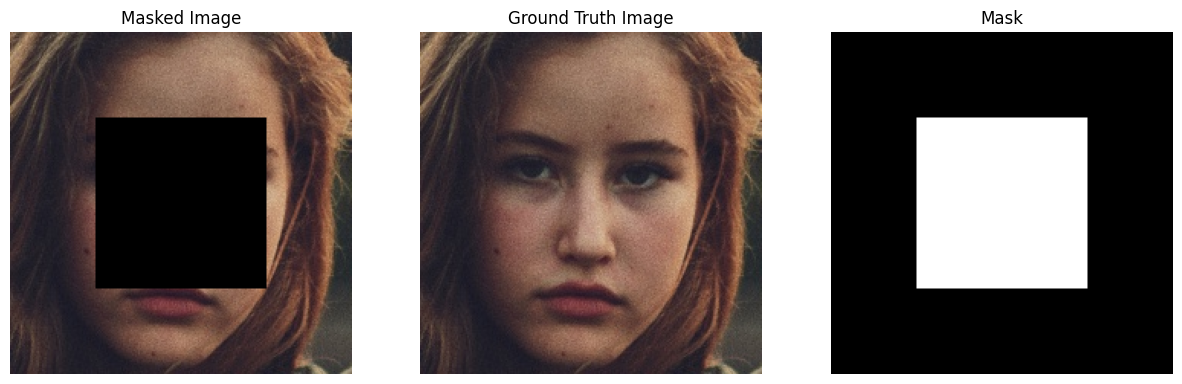

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


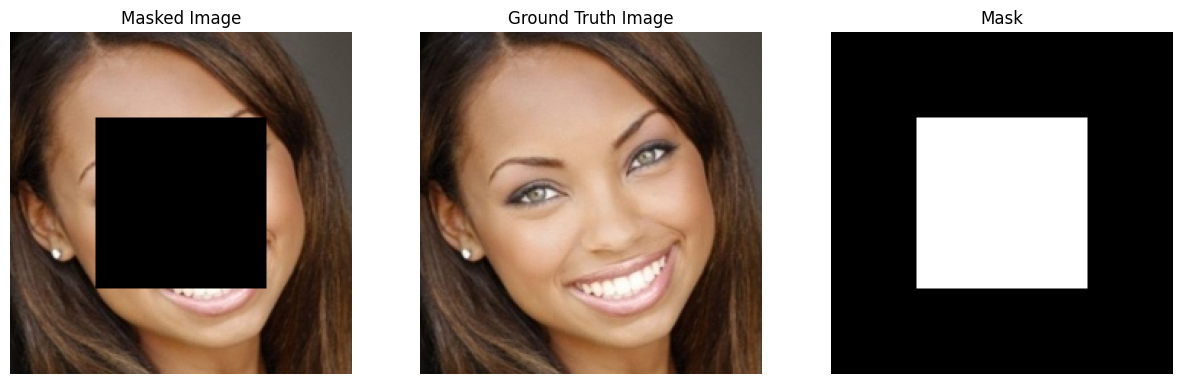

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


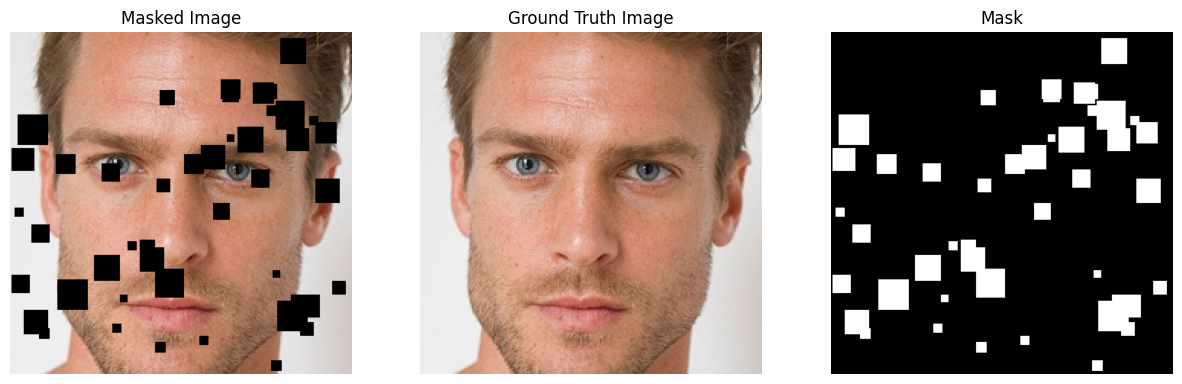

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


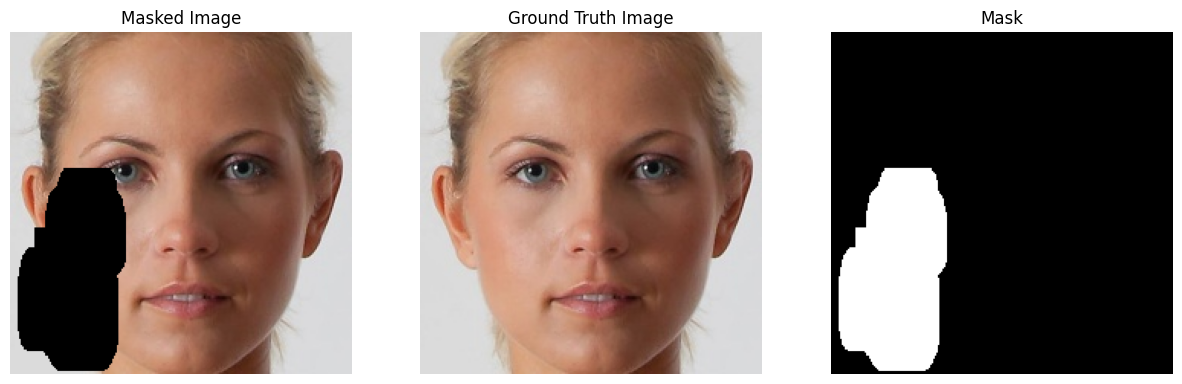

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


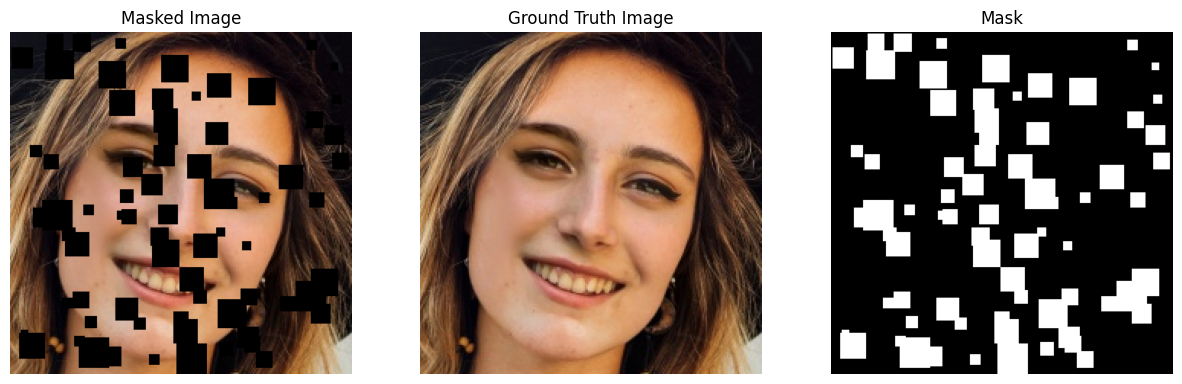

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


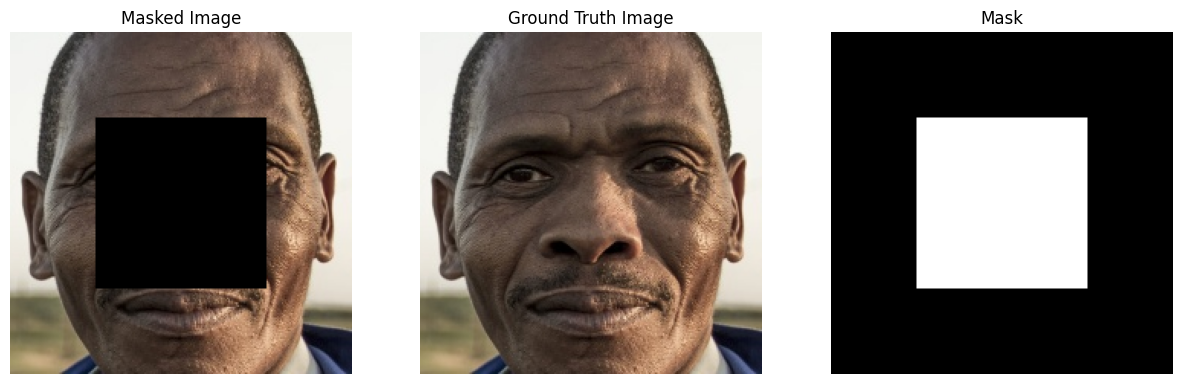

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


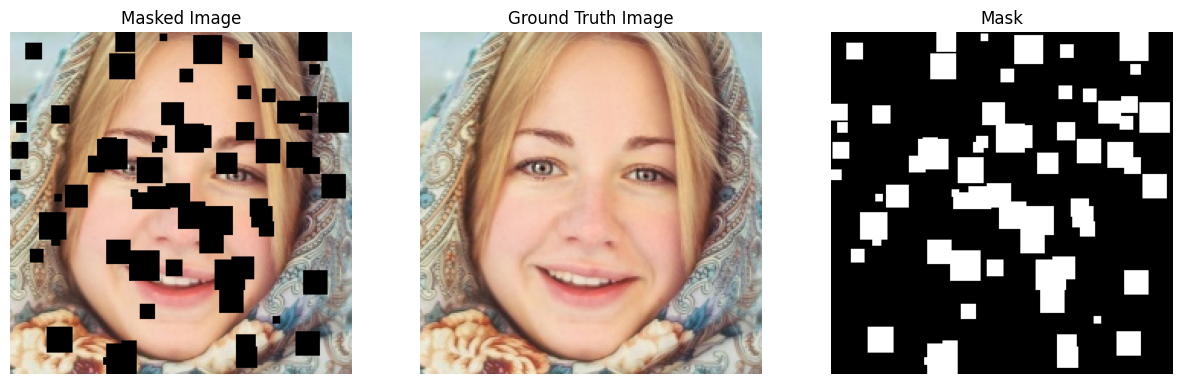

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


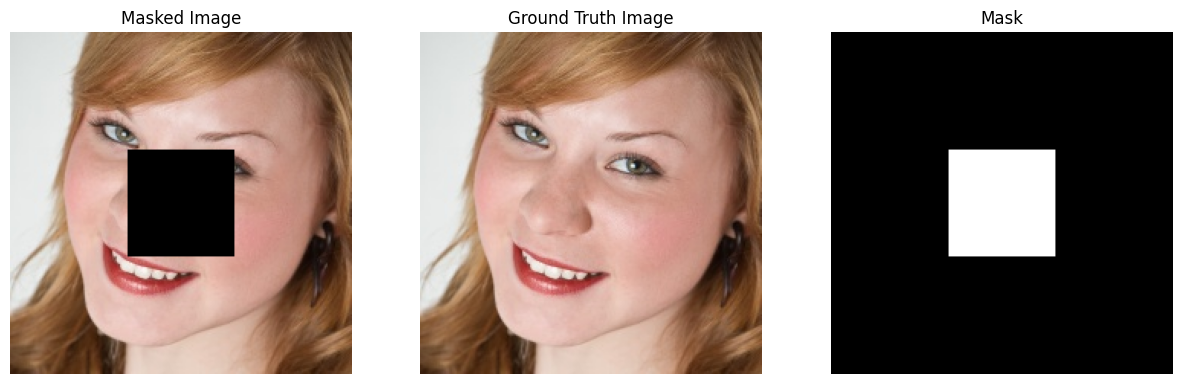

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


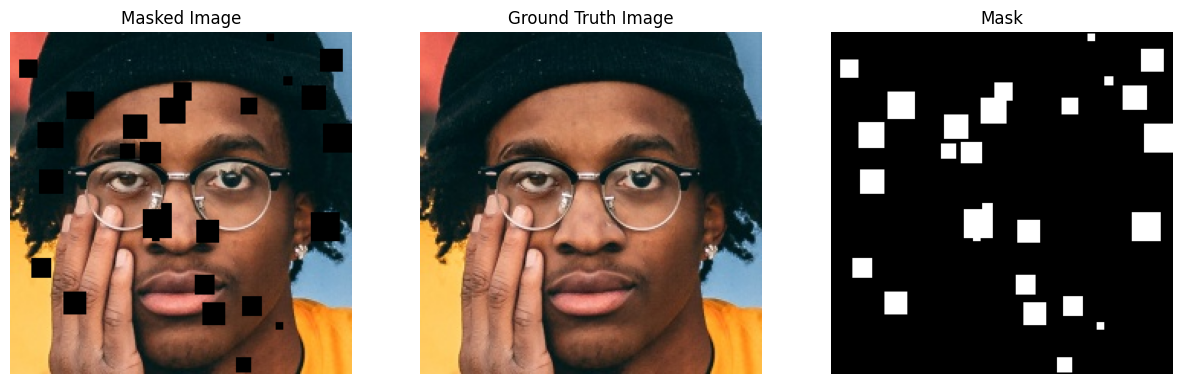

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


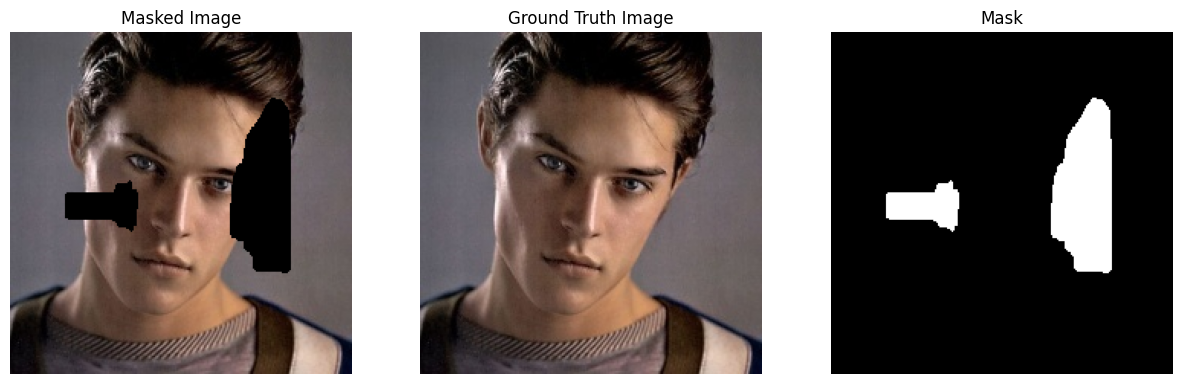

Masked Image shape: torch.Size([32, 3, 224, 224]), Ground Truth shape: torch.Size([32, 3, 224, 224]), Mask shape: torch.Size([32, 224, 224])


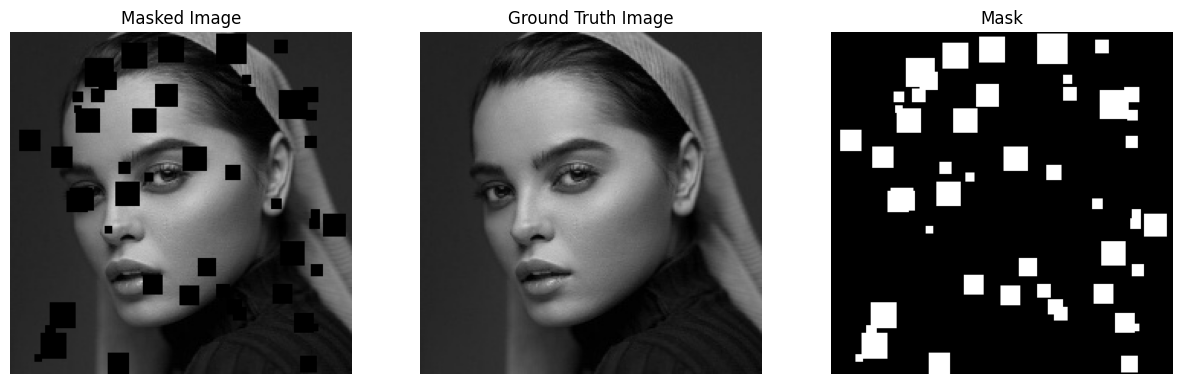

In [23]:

def tensor_to_image(tensor):
    image = tensor.permute(1, 2, 0).numpy()
    # Clip values to the valid range for images (0-255)
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    return image

"""
def reverse_normalization(tensor, mean, std):
    
    Reverse the normalization by multiplying by std and adding mean.
    Args:
        tensor: Tensor of shape (C, H, W)
        mean: Mean for each channel (C,)
        std: Std for each channel (C,)
    Returns:
        tensor: Denormalized tensor
    
    mean = torch.tensor(mean).view(3, 1, 1)  # Make mean shape (C, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)    # Make std shape (C, 1, 1)
    
    # Reverse the normalization
    tensor = tensor * std + mean
    return tensor
"""

"""
def tensor_to_image(tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    
    #Converts a tensor to a NumPy image after reversing normalization.
    
    
    # Reverse normalization
    tensor = reverse_normalization(tensor, mean, std)
    
    # Ensure the values are in the valid range [0, 1] before converting
    tensor = tensor.clamp(0, 1)  # Clamping the tensor values in the [0, 1] range
    
    # Convert from Tensor (C, H, W) to (H, W, C) and then to a NumPy array
    image = tensor.permute(1, 2, 0).numpy()
    
    # Convert values to the range [0, 255]
    image = np.clip(image, 0, 1)  # Ensure the values are within [0, 1]
    image = (image * 255).astype(np.uint8)  # Convert to 8-bit per channel
    
    return image
"""
print(len(train_loader))
for masked_images, ground_truth_images, masks in train_loader:
    for i in range(masked_images.shape[0]):
        print(f"Masked Image shape: {masked_images.shape}, Ground Truth shape: {ground_truth_images.shape}, Mask shape: {masks.shape}")
        masked_image = tensor_to_image(masked_images[i])
        ground_truth_image = tensor_to_image(ground_truth_images[i])
        mask = masks[i].numpy()  # Mask is in shape (H, W), no need to permute
        
        # Plot the images
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
        # Display masked image
        axes[0].imshow(masked_image)
        axes[0].set_title("Masked Image")
        axes[0].axis('off')
    
        # Display ground truth image
        axes[1].imshow(ground_truth_image)
        axes[1].set_title("Ground Truth Image")
        axes[1].axis('off')
    
        # Display mask (mask is a binary image, so display it as grayscale)
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title("Mask")
        axes[2].axis('off')
    
        plt.show()
    #Only 1 batch
    break;
    

In [31]:
# Custom ResNet34 Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channel, out_channel, padding, downsample, batch_norm):
        super(ResNetBlock, self).__init__()
        if(downsample):
            temp_stride = 2
        else:
            temp_stride = 1
        self.batchnorm_bool = batch_norm
        self.outchannel = out_channel
        
        
        self.conv_a = nn.Conv2d(in_channel, out_channel, kernel_size = (3,3), stride = temp_stride, padding = padding)
        nn.init.kaiming_normal_(self.conv_a.weight, mode='fan_out', nonlinearity='relu')

        self.conv_b = nn.Conv2d(out_channel, out_channel, kernel_size = (3,3), stride = 1, padding = padding)
        nn.init.kaiming_normal_(self.conv_b.weight, mode='fan_out', nonlinearity='relu')

        self.conv_short = nn.Conv2d(in_channel, out_channel, kernel_size = (1,1),  stride = temp_stride)
        nn.init.kaiming_normal_(self.conv_short.weight, mode='fan_out', nonlinearity='relu')

        self.relu = nn.ReLU(inplace=True)
        self.batchnorm_a = nn.BatchNorm2d(out_channel)
        self.batchnorm_b = nn.BatchNorm2d(out_channel)
        self.batchnorm_short = nn.BatchNorm2d(out_channel)
        
        
        
    def forward(self, x):
        old_x = x
        
        a_output=self.conv_a(x)
        if self.batchnorm_bool: a_output=self.batchnorm_a(a_output)
        a_output = self.relu(a_output)
        
        b_output = self.conv_b(a_output)
        if self.batchnorm_bool: b_output=self.batchnorm_b(b_output)
        b_output = self.relu(b_output)
        
        if(self.outchannel == 64):
            residual =  x
        else:
            residual =  self.conv_short(old_x)
        if self.batchnorm_bool: residual=self.batchnorm_short(residual)
        #print(b_output.size())
        #print(residual.size())
        out = self.relu(b_output + residual)
        return out



class ChannelWiseFullyConnected(nn.Module):
    def __init__(self, channels, height, width):
        super(ChannelWiseFullyConnected, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width
        self.num_features = height * width
        
        # One independent linear layer per channel (each maps n^2 -> n^2)
        self.fc_layers = nn.ModuleList([
            nn.Linear(self.num_features, self.num_features) for _ in range(channels)
        ])
    
    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        batch_size = x.size(0)
        
        out = []
        for c in range(self.channels):
            # Flatten H x W into a vector
            channel = x[:, c, :, :].view(batch_size, -1)
            # Apply channel-specific FC layer
            channel_fc = self.fc_layers[c](channel)
            # Reshape back to H x W
            channel_fc = channel_fc.view(batch_size, self.height, self.width)
            out.append(channel_fc.unsqueeze(1))  # add back channel dim
        
        # Concatenate channels back: shape [batch_size, channels, height, width]
        return torch.cat(out, dim=1)


# Custom ResNet34 Encoder (Manual Implementation)
class ResNetEncoder(nn.Module):
    def __init__(self, latent_dim=512):
        super(ResNetEncoder, self).__init__()

         # Encoder (Rest 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        """
        self.rest_of_encoder = nn.Sequential(
            #CONV LAYER 2
            ResNetBlock(64, 64, 1, True, True),
            ResNetBlock(64, 64, 1, False, True),
            ResNetBlock(64, 64, 1, False, True),
    
            #CONV LAYER 3
            ResNetBlock(64, 128, 1, True, True),
            ResNetBlock(128, 128, 1, False, True),
            ResNetBlock(128, 128, 1, False, True),
            ResNetBlock(128, 128, 1, False, True),
    
            #CONV LAYER 4
            ResNetBlock(128, 256, 1, True, True),
            ResNetBlock(256, 256, 1, False, True),
            ResNetBlock(256, 256, 1, False, True),
            ResNetBlock(256, 256, 1, False, True),
            ResNetBlock(256, 256, 1, False, True),
            ResNetBlock(256, 256, 1, False, True),
    
            #CONV LAYER 5
            ResNetBlock(256, 512, 1, True, True),
            ResNetBlock(512, 512, 1, False, True),
            ResNetBlock(512, 512, 1, False, True),
        )
        """
        
        """
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        """
        # ResNet34 layers

        #CONV LAYER 2
        self.conv2_1 = ResNetBlock(64, 64, 1, False, True)
        self.conv2_2 = ResNetBlock(64, 64, 1, False, True)
        self.conv2_3 = ResNetBlock(64, 64, 1, False, True)

        #CONV LAYER 3
        self.conv3_1 = ResNetBlock(64, 128, 1, True, True)
        self.conv3_2 = ResNetBlock(128, 128, 1, False, True)
        self.conv3_3 = ResNetBlock(128, 128, 1, False, True)
        self.conv3_4 = ResNetBlock(128, 128, 1, False, True)

        #CONV LAYER 4
        self.conv4_1 = ResNetBlock(128, 256, 1, True, True)
        self.conv4_2 = ResNetBlock(256, 256, 1, False, True)
        self.conv4_3 = ResNetBlock(256, 256, 1, False, True)
        self.conv4_4 = ResNetBlock(256, 256, 1, False, True)
        self.conv4_5 = ResNetBlock(256, 256, 1, False, True)
        self.conv4_6 = ResNetBlock(256, 256, 1, False, True)

        #CONV LAYER 5
        self.conv5_1 = ResNetBlock(256, 512, 1, True, True)
        self.conv5_2 = ResNetBlock(512, 512, 1, False, True)
        self.conv5_3 = ResNetBlock(512, 512, 1, False, True)
        
        
        self.channel_fc = ChannelWiseFullyConnected(channels=512, height=7, width=7)
        self.conv_fc = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0)
        
        
        
        # Decoder (Upsampling to reconstruct image)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Output range [0,1]
        )
    
    def forward(self, x):
        # Encoder
        #print(x.size())
        x = self.conv1(x)
        #print(x.size())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.size())
        layer_2 = self.conv2_3(self.conv2_2(self.conv2_1(x)))
        layer_3 = self.conv3_4(self.conv3_3(self.conv3_2(self.conv3_1(layer_2))))
        layer_4 = self.conv4_6(self.conv4_5(self.conv4_4(self.conv4_3(self.conv4_2(self.conv4_1(layer_3))))))
        layer_5 = self.conv5_3(self.conv5_2(self.conv5_1(layer_4)))
        #raise RuntimeError(f"{layer_5.size()}")
        #x = self.rest_of_encoder(x)
        cfc = self.conv_fc(self.channel_fc(layer_5))
        # Decoder
        out = self.decoder(cfc)  # Convert features back to an image
        return out


In [42]:
#As defined within the paper

class ReconstructionLoss(nn.Module):
    def __init__(self):
        super(ReconstructionLoss, self).__init__()

    def forward(self, output, ground_truth, mask):
        # output is F((1 - M_hat) * x)
        # ground_truth is x
        # mask is M_hat
        
        # Convert mask to float, if not already
        mask = mask.float()

        # Expand mask to 3 channels to match output and ground_truth
        mask_3ch = mask.unsqueeze(1).repeat(1, 3, 1, 1)

        # Compute the error
        error = ground_truth - output

        # Apply the mask
        masked_out_error = mask_3ch * error

        # Sum over masked pixels
        pixel_amount = mask_3ch.sum()

        # Compute squared L2 norm
        squared_l2_norm = torch.sum(masked_out_error ** 2)

        # Normalize, add epsilon for numerical stability
        return squared_l2_norm / (pixel_amount + 1e-8)

In [43]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"CUDA is available. Number of GPUs: {device_count}")
    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("CUDA is not available.")

print(torch.version.cuda)
print(torch.cuda.is_available())


CUDA is available. Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3070 Laptop GPU
12.1
True


In [44]:
model_path_dir = "./model_paths/"
os.path.isdir("./model_paths/")

True

In [49]:
# Initialize model (Make sure ResNetEncoder is already defined)
def train_RESNET_ENCODER(lr, epochs, batch_size):   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #print(device)
    model = ResNetEncoder().to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    # Define loss function and optimizer
    criterion = ReconstructionLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Now model exists
    train_losses = []
    validation_losses = []

    #dataset = CustomInpaintingDataset(image_paths, occlusion_percentages=[0.10, 0.25, 0.50], transform=transform)

    # Create DataLoader
    #dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    # Training loop
    # Adjust based on dataset
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_val_loss = 0
        progress_bar_string = f"Progress on Epoch {epoch+1}"
        for masked_images, ground_truth_images, masks in tqdm(train_loader, desc = progress_bar_string):  
            
            masked_images, ground_truth_images, masks = (
                masked_images.to(device, non_blocking=True), 
                ground_truth_images.to(device, non_blocking=True), 
                masks.to(device, non_blocking=True)  # Move masks to device
            )

            optimizer.zero_grad()

            training_outputs = model(masked_images)  # Forward pass
            training_loss = criterion(training_outputs, ground_truth_images, masks)  # Compute loss 
            training_loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            epoch_loss += training_loss.item()
            

            
        model.eval()  # Set model to evaluation mode
        
            # Grab the next validation batch
        
        for val_inputs, val_ground_truths, val_masks in val_loader:
            val_inputs = val_inputs.to(device, non_blocking = True)
            val_ground_truths = val_ground_truths.to(device, non_blocking=True)
            val_masks = val_masks.to(device, non_blocking=True)

            
            with torch.no_grad():
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_ground_truths, val_masks)
            epoch_val_loss += val_loss.item()

        model.train()
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss/len(train_loader):.4f}, Validation Loss: {epoch_val_loss/len(val_loader):.4f}")
        train_losses.append(epoch_loss/len(train_loader))
        validation_losses.append(epoch_val_loss/len(val_loader))

    print("Training Complete!")

    
    

    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    epoch_range = range(1, epochs+1)
    # Plot Training Loss
    ax.plot(epoch_range, train_losses, label='Training Loss', color = "blue")
    ax.plot(epoch_range, validation_losses, label='Validation Loss', color = "orange")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss Curve')
    ax.legend()

    plt.show()
    
    """
    axes[0].plot(epoch_range, train_losses, label='Training Loss', color='blue')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'Training Loss Curve (B: {batch_size}, E: {epochs}, LR: {lr})')
    axes[0].legend()

    # Plot Validation Loss
    axes[1].plot(epoch_range, validation_losses, label='Validation Loss', color='orange')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'Training Loss Curve (B: {batch_size}, E: {epochs}, LR: {lr})')
    axes[1].legend()
    """
    #plt.tight_layout()  # Adjust spacing to prevent overlap
    #plt.show()
    model_path = os.path.join(model_path_dir, f"resnet34_lr{lr}_epoch{epoch}_batch{batch_size}_trial.pth")
    checkpoint = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'val_loss': validation_losses,
        'hyperparameters': {
            'lr': lr,
            'batch_size': batch_size,
            # add more if needed
        }
    }
    torch.save(checkpoint, model_path)
    print(f"Model saved to {model_path}, cleaning required")
    del model
    del optimizer
    del train_loader
    del val_loader
    del masked_images
    del ground_truth_images
    del masks
    del val_inputs
    del val_ground_truths
    del val_masks
    torch.cuda.empty_cache()
    gc.collect()

    return train_losses[-1], validation_losses[-1], model_path


In [50]:
#Initial Tuning
batches = [32, 64]
lrs = [0.01, 0.001, 0.0001]
epochs = [10, 25, 50]
i = 0
best_train_loss = 100
best_validation_loss = 100
best_model = None
best_batch_size = 0
best_lr= 0
best_epoch = 0
best_trial = 0
model_list = []
for batch_size in batches:
    for lr in lrs:
        for epoch in epochs:
            i+=1
            print(f"Trial {i} with parameters batch_size: {batch_size}, lr: {lr}, epochs: {epoch}------------------------------------------------------")
            current_train_loss, current_validation_loss, current_model = train_RESNET_ENCODER(lr = lr, epochs = epoch, batch_size = batch_size)
            model_list.append(current_model)
            if((current_train_loss <= best_train_loss) and (current_validation_loss <= best_validation_loss)):
                best_model = current_model
                best_batch_size = batch_size
                best_lr= lr
                best_epoch = epoch 
                best_trial = i
            print(f"Trial {i} complete----------------------------------------------------------------------------------------------------------------")

print(f"Best model with parameters batch_size: {best_batch_size}, lr: {best_lr}, epochs: {best_epoch}")

Trial 1 with parameters batch_size: 32, lr: 0.01, epochs: 10------------------------------------------------------


Progress on Epoch 1:   5%|▌         | 25/475 [00:14<04:27,  1.68it/s]


KeyboardInterrupt: 

In [ ]:
# Define model checkpoint path
model_path = "resnet34_context_encoder.pth"
if os.path.exists(model_path):
    print(f"Model found at: {model_path}")
else:
    print(f" Model file NOT found in: {os.getcwd()}")
    print("Please check the file path or move the file to the correct location.")

In [ ]:
#impaint masked images
# Pass masked images through the model to get inpainted results
with torch.no_grad():
    inpainted_images = model(masked_images.to(device))


In [ ]:
#convert tensors to images

def tensor_to_image(tensor, mask = False):
    tensor = tensor.cpu().detach().numpy()
    tensor = np.transpose(tensor, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    if(not mask):
        tensor = (tensor * 255).astype(np.uint8)  # Convert to 0-255 range
    else:
        tensor = np.clip(tensor, 0, 1)
        
    return tensor
'''
def tensor_to_image(tensor):
    image = tensor.cpu().detach().numpy()  # Move to CPU and convert to NumPy
    image = np.transpose(image, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    image = np.clip(image, 0, 1)  # Clip values to valid range (0-1)
    return image
'''
# Get a batch from the DataLoader
model.eval()  # Set model to evaluation mode

with torch.no_grad():  # No gradient computation for inference
    for masked_images, ground_truth_images, masks in test_loader:
        masked_images = masked_images.to(device)
        ground_truth_images = ground_truth_images.to(device)

        predicted_images = model(masked_images)  # Model predicts inpainted images
        break  # Take only one batch for visualization


In [ ]:
# Plot Original, Masked, and Inpainted Images
num_images=15
fig, axes = plt.subplots(num_images, 3, figsize=(20, 80))

for i in range(num_images):
    # Convert tensors to images
    #print(masks[i].unsqueeze(0).size())
    mask = tensor_to_image(masks[i].unsqueeze(0), mask = True)
    print(np.unique(mask))
    masked_img = tensor_to_image(masked_images[i])
    print(np.unique(masked_img)[-5:])
    
    predicted_img = tensor_to_image(predicted_images[i])
    mask_predicted = np.multiply(predicted_img, mask).astype(int)
    patches_predicted = np.add(masked_img, mask_predicted).astype(int)
    #print(predicted_img.dtype)
    #predicted_img = tensor_to_image(predicted_images[i])
    #print(predicted_img.dtype)
    #print(np.unique(predicted_img))
    
    ground_truth_img = tensor_to_image(ground_truth_images[i])

    # Display masked image
    axes[i, 0].imshow(masked_img)
    axes[i, 0].set_title("Masked Image")
    axes[i, 0].axis("off")

    # Display predicted inpainted image
    axes[i, 1].imshow(patches_predicted)
    axes[i, 1].set_title("Predicted Patching")
    axes[i, 1].axis("off")

    # Display original ground truth image
    axes[i, 2].imshow(ground_truth_img)
    axes[i, 2].set_title("Ground Truth")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()